<a href="https://colab.research.google.com/github/meliksahb/501-DeepLearning/blob/main/CENG_501_PyTorch_MLP_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a MLP model on MNIST using PyTorch

Sample MNIST images:

![MNIST examples](https://www.researchgate.net/profile/Stefan_Elfwing/publication/266205382/figure/fig5/AS:267913563209738@1440886979379/Example-images-of-the-ten-handwritten-digits-in-the-MNIST-training-set.png)

- 10 classes
- 60 thousand training images
- 10 thousand testing images
- Each image is monochrome, 28-by-28 pixels.

In [1]:
#@title Import the required modules
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
# Define the "device". If GPU is available, device is set to use it, otherwise CPU will be used.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#@title Download the dataset
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.28MB/s]


In [4]:
# About the ToTensor() transformation.

# PyTorch networks expect a tensor as input with dimensions N*C*H*W  where
# N: batch size
# C: channel size
# H: height
# W: width

# Normally an image is of size H*W*C.
# ToTensor() transformation moves the channel dimension to the beginning as needed by PyTorch.

In [35]:
#@title Define the data loaders
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset =  test_data ,
                                      batch_size = batch_size,
                                      shuffle = False)

In [43]:
#@title Define a MLP network

class MLP(nn.Module):
  def __init__(self, input_size, num_hidden_neurons, num_classes):
    super(MLP,self).__init__()
    self.fc1 = nn.Linear(input_size, num_hidden_neurons)
    self.fc2 = nn.Linear(num_hidden_neurons, num_hidden_neurons)
    self.fc3 = nn.Linear(num_hidden_neurons, (num_hidden_neurons)//2)
    self.fc4 = nn.Linear((num_hidden_neurons)//2, num_classes)
    self.relu = nn.ReLU()

  def forward(self,input):
    x = self.relu(self.fc1(input))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [44]:
#@title Create a MLP network instance

input_size = 28*28
num_hidden_neurons = 128
num_classes = 10

net = MLP(input_size, num_hidden_neurons, num_classes)
net.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [45]:
#@title Define the loss function and the optimizer
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( net.parameters(), lr=0.001, momentum=.9)

In [46]:
#@title Train the model

num_epochs = 20
losses = []
iter_nums = []
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.view(-1,28*28).to(device)
    labels = labels.to(device)

    optimizer.zero_grad()             # reset the gradient cache
    output = net(images)              # forward pass
    loss = loss_fun(output, labels)   # compute loss
    loss.backward()                   # backward pass: compute the gradient
    optimizer.step()                  # update model parameters

    if (i+1) % batch_size == 0:
      losses.append(loss.item())
      iter_nums.append(epoch*len(train_loader)+i)
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

Epoch [1/20], Step [100/600], Loss: 2.3024
Epoch [1/20], Step [200/600], Loss: 2.2929
Epoch [1/20], Step [300/600], Loss: 2.2826
Epoch [1/20], Step [400/600], Loss: 2.2783
Epoch [1/20], Step [500/600], Loss: 2.2608
Epoch [1/20], Step [600/600], Loss: 2.2260
Epoch [2/20], Step [100/600], Loss: 2.1853
Epoch [2/20], Step [200/600], Loss: 2.1633
Epoch [2/20], Step [300/600], Loss: 2.0081
Epoch [2/20], Step [400/600], Loss: 1.7831
Epoch [2/20], Step [500/600], Loss: 1.5651
Epoch [2/20], Step [600/600], Loss: 1.3137
Epoch [3/20], Step [100/600], Loss: 1.1776
Epoch [3/20], Step [200/600], Loss: 1.0308
Epoch [3/20], Step [300/600], Loss: 0.7980
Epoch [3/20], Step [400/600], Loss: 0.7470
Epoch [3/20], Step [500/600], Loss: 0.5629
Epoch [3/20], Step [600/600], Loss: 0.8036
Epoch [4/20], Step [100/600], Loss: 0.6684
Epoch [4/20], Step [200/600], Loss: 0.5137
Epoch [4/20], Step [300/600], Loss: 0.6247
Epoch [4/20], Step [400/600], Loss: 0.5384
Epoch [4/20], Step [500/600], Loss: 0.5426
Epoch [4/20

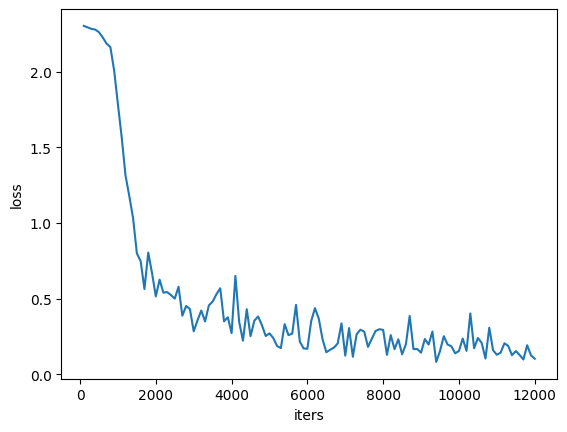

In [47]:
import matplotlib.pyplot as plt

plt.plot(iter_nums,losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.show()

In [48]:
#@title Run the trained model on the testing set

correct = 0
total = 0
for images,labels in test_loader:
  images = images.view(-1,28*28).to(device)
  labels = labels.to(device)

  out = net(images)
  _, predicted_labels = torch.max(out,1)
  correct += (predicted_labels == labels).sum()
  total += labels.size(0)

print('Percent correct: %.3f %%' %((100*correct)/(total+1)))

Percent correct: 94.961 %


End of the notebook.